Coeficiente (privado): 3.066
Intercepto: -6.833

Probabilidad estimada de ofrecer idioma extranjero:
  tipo_institucion  probabilidad
0          Público      0.001076
1          Privado      0.022593


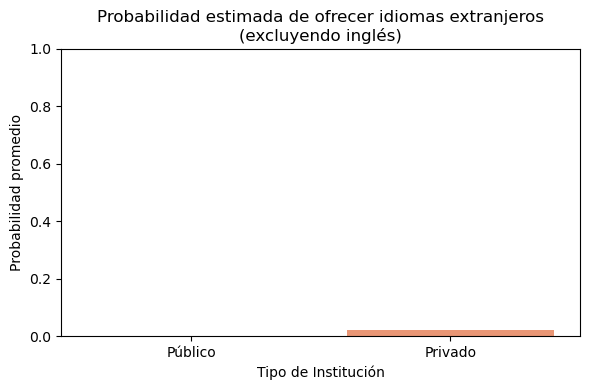


Tabla de conteo real de idiomas (cada idioma contado individualmente) por tipo de institución:
idioma            aleman  frances  hebreo  italiano
tipo_institucion                                   
Privado               17      185      88         5
Público                1        6       1         0


In [8]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Cargar el archivo limpio
df = pd.read_csv('../data/limpio/establecimientos_educativos_limpio.csv')

# 2. Crear columna 'ofrece_idioma_extranjero' (excluyendo inglés)
def ofrece_idioma_extranjero(idiomas):
    if not isinstance(idiomas, str):
        return 0
    idiomas_lista = [i.strip().lower() for i in idiomas.split(',')]
    idiomas_validos = [i for i in idiomas_lista if i not in ['', '-', 'nan', 'ninguno']]
    return int(any(i not in ['ingles', 'inglés'] for i in idiomas_validos))

df['ofrece_idioma_extranjero'] = df['idiomas'].apply(ofrece_idioma_extranjero)

# 3. Clasificar prestador_de_servicio como público (0) o privado (1)
prestadores_publicos =  {'OFICIAL', 'CONCESION', 'EDUCACION MISIONAL CONTRATADA', 'REGIMEN ESPECIAL'}

def clasificar_privado(prestador):
    if isinstance(prestador, str):
        if prestador.strip().upper() in prestadores_publicos:
            return 0
    return 1

df['privado'] = df['prestador_de_servicio'].apply(clasificar_privado)

# 4. Filtrar columnas para modelar
df_model = df[['privado', 'ofrece_idioma_extranjero']].dropna().copy()

# 5. Entrenar modelo de regresión logística
X = df_model[['privado']]
y = df_model['ofrece_idioma_extranjero']

modelo = LogisticRegression()
modelo.fit(X, y)

# 6. Obtener probabilidades predichas
df_model['probabilidad'] = modelo.predict_proba(X)[:, 1]

# 7. Mostrar coeficiente e intercepto
coef = modelo.coef_[0][0]
intercepto = modelo.intercept_[0]

print(f"Coeficiente (privado): {coef:.3f}")
print(f"Intercepto: {intercepto:.3f}")

# 8. Promedio de probabilidad por tipo de institución
prob_por_tipo = df_model.groupby('privado')['probabilidad'].mean().reset_index()
prob_por_tipo['tipo_institucion'] = prob_por_tipo['privado'].map({0: 'Público', 1: 'Privado'})

print("\nProbabilidad estimada de ofrecer idioma extranjero:")
print(prob_por_tipo[['tipo_institucion', 'probabilidad']])

# 9. Gráfica
plt.figure(figsize=(6,4))
sns.barplot(x='tipo_institucion', y='probabilidad', data=prob_por_tipo, hue='tipo_institucion', palette='Set2', legend=False)
plt.title('Probabilidad estimada de ofrecer idiomas extranjeros\n(excluyendo inglés)')
plt.ylabel('Probabilidad promedio')
plt.xlabel('Tipo de Institución')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# 10. Conteo real de idiomas por tipo de institución (cada idioma cuenta individualmente)
idioma_registros = []

for _, fila in df.iterrows():
    if not isinstance(fila['idiomas'], str):
        continue
    idiomas_lista = [i.strip().lower() for i in fila['idiomas'].split(',')]
    idiomas_validos = [i for i in idiomas_lista if i not in ['', '-', 'nan', 'ninguno', 'ingles', 'inglés']]
    for idioma in idiomas_validos:
        idioma_registros.append({
            'tipo_institucion': 'Público' if fila['privado'] == 0 else 'Privado',
            'idioma': idioma
        })

df_idiomas = pd.DataFrame(idioma_registros)

tabla_idiomas = pd.crosstab(df_idiomas['tipo_institucion'], df_idiomas['idioma'])

print("\nTabla de conteo real de idiomas (cada idioma contado individualmente) por tipo de institución:")
print(tabla_idiomas)
